# Insurance Forecast

The dataset give us some fatures to try forecasting the insurance value.

- *age:* age of primary beneficiary.
- *sex:* insurance contractor gender, female, male.
- *bmi:* Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- *children:* Number of children covered by health insurance / Number of dependents.
- *smoker:* Smoking.
- *region:* the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- *charges:* Individual medical costs billed by health insurance.

We are a Data Scientists of an Insurance Company and we have some tasks to help business improve our profits:
1. know which group of clients are the most profitable 
2. make a model to apply insurance values to new clients

In [ ]:
# importing libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import math

import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Suprimir todos os warnings
warnings.filterwarnings("ignore")

In [ ]:
# loading data
raw_data = pd.read_csv('datasets/insurance.csv')
raw_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Data Cleaning

Here we are looking for inconsistences, missing values, outliers and a lot of things we can improve our dataset.
1. Inconsistences
2. Missing Values
3. Duplicated Values
4. Outliers

In [ ]:
# checking for inconsistences
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### 3. Drop Dulicated Values

In [ ]:
# Checking quantiative features
quantitative_cols = raw_data.select_dtypes(include=['int', 'float'])
quantitative_cols.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
# Valores duplicados
print(f'valores duplicados: {raw_data.duplicated().sum()}')
if raw_data.duplicated().sum() > 0:
    raw_data.drop_duplicates(inplace= True)
    print('... droping duplicated')
    print(f'valores duplicados: {raw_data.duplicated().sum()}')
else:
    print(f'não há valores duplicados')

valores duplicados: 1
... droping duplicated
valores duplicados: 0


### 4. Cliping Outliers

In [ ]:

fig = make_subplots(rows= 1, cols= len(quantitative_cols.columns), shared_yaxes= False)

for i in np.arange(0, len(quantitative_cols.columns), 1):

    fig.add_trace(go.Box(y= quantitative_cols[quantitative_cols.columns[i]], name= quantitative_cols.columns[i]),
                   row= 1,
                   col= i+1)

fig.show()

In [ ]:
def clip_outliers(df, feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1

    limite_superior = q3 + 1.5 * iqr
    limite_inferior = q1 - 1.5 * iqr

    # Filtrar as linhas que estão dentro dos limites
    df_sem_outliers = df[(df[feature] >= limite_inferior) & (df[feature] <= limite_superior)]
    return df_sem_outliers

features = quantitative_cols.columns[[1,3]]
for i in features:
    dataframe = clip_outliers(raw_data, i)

In [ ]:
fig = make_subplots(rows= 1, cols= len(quantitative_cols.columns), shared_yaxes= False)

for i in np.arange(0, len(quantitative_cols.columns), 1):

    fig.add_trace(go.Box(y= dataframe[quantitative_cols.columns[i]], name= quantitative_cols.columns[i]),
                   row= 1,
                   col= i+1)

fig.show()

In [ ]:
dataframe.describe()

,age,bmi,children,charges
count,1198.000000,1198.000000,1198.000000,1198.000000
mean,39.006678,30.094787,1.085142,9934.671758
std,14.062040,6.013044,1.214407,7240.216987
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,25.800000,0.000000,4418.591062
50%,39.000000,29.735000,1.000000,8411.754950
75%,51.000000,33.820000,2.000000,12955.356300
max,64.000000,53.130000,5.000000,34472.841000


# Exploratory Analysis



In [ ]:
def range_age(df, feature):
    n = len(df)

    # number of divisions
    #k = math.ceil(1 + 3.3 * np.log(n))
    k = 7

    # interval between divisions
    A = max(df[feature]) - min(df[feature])
    h = math.ceil(A/k)

    intervalos = [min(df[feature]) + i * h for i in range(k)]
    dados_com_intervalos = [min(range(len(intervalos)), key=lambda i: abs(valor - intervalos[i])) for valor in df[feature]]
    return dados_com_intervalos

dataframe['age_interval'] = range_age(dataframe, 'age')

In [ ]:
dataframe.head()

,age,sex,bmi,children,smoker,region,charges,age_interval
0,19,female,27.900,0,yes,southwest,16884.92400,0
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,1
3,33,male,22.705,0,no,northwest,21984.47061,2
4,32,male,28.880,0,no,northwest,3866.85520,2


# What's the most profitable group of clients

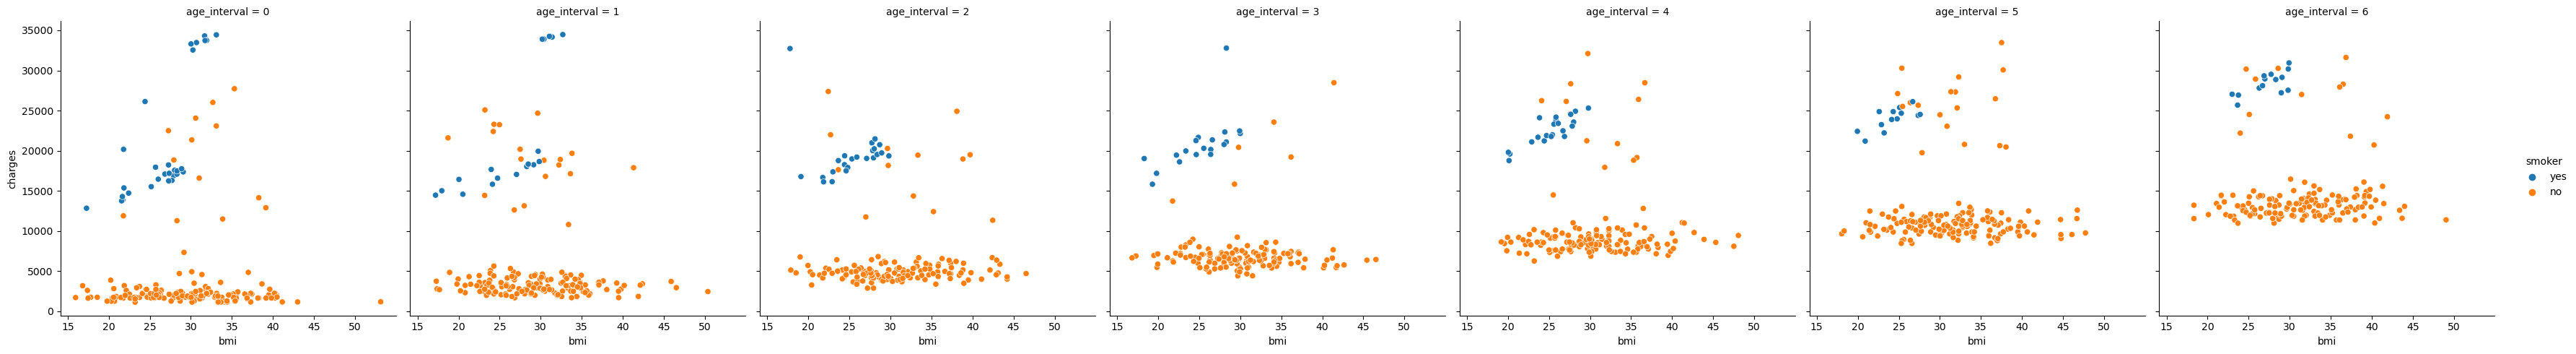

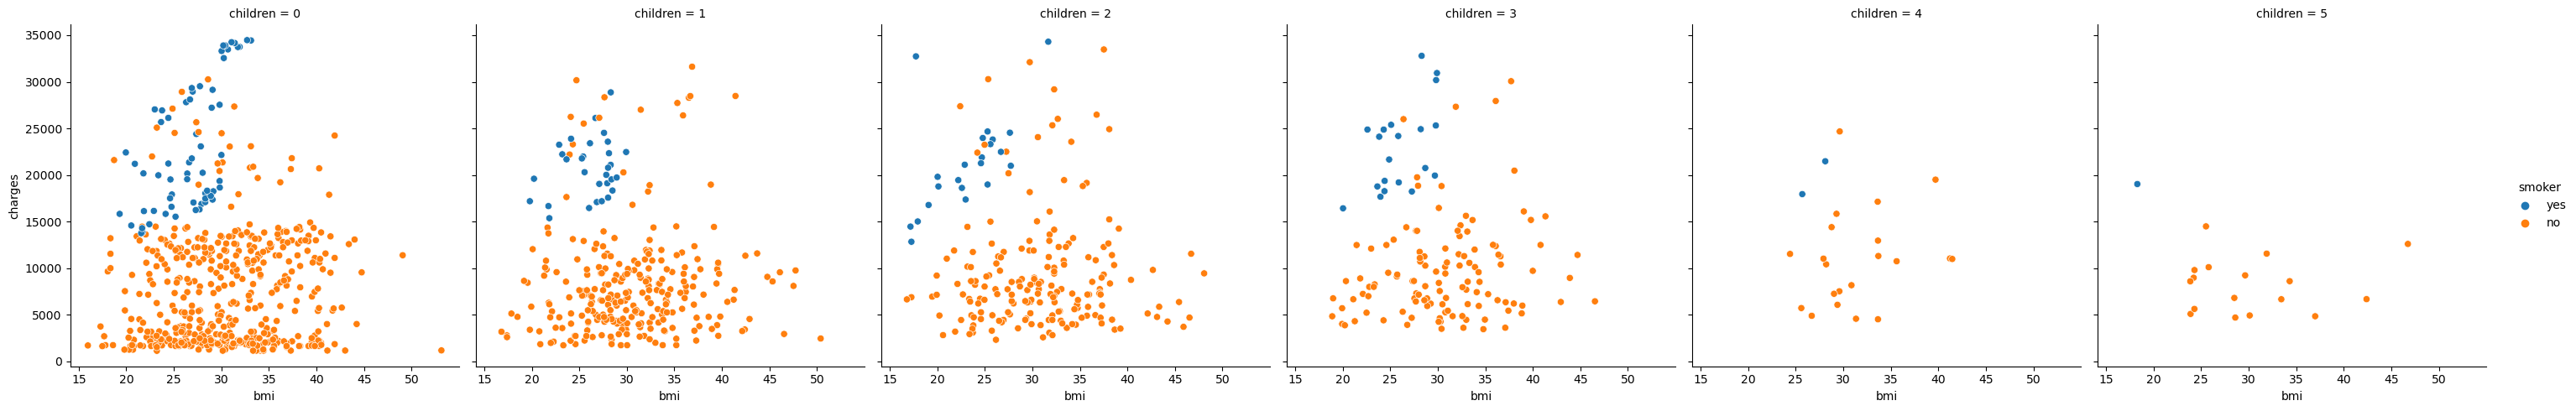

In [ ]:
sns.relplot(data=dataframe, x='bmi', y='charges', hue='smoker', col='age_interval')
sns.relplot(data=dataframe, x='bmi', y='charges', hue='smoker', col='children')
plt.show()

In [ ]:
dataframe[['sex', 'smoker', 'region']] = dataframe[['sex', 'smoker', 'region']].astype('category')
dataframe.drop('age', axis=1, inplace=True)
dataframe.head()

,sex,bmi,children,smoker,region,charges,age_interval
0,female,27.900,0,yes,southwest,16884.92400,0
1,male,33.770,1,no,southeast,1725.55230,0
2,male,33.000,3,no,southeast,4449.46200,1
3,male,22.705,0,no,northwest,21984.47061,2
4,male,28.880,0,no,northwest,3866.85520,2


In [ ]:
label = LabelEncoder()
label.fit(dataframe.sex.drop_duplicates())
dataframe.sex = label.transform(dataframe.sex)
label.fit(dataframe.smoker.drop_duplicates())
dataframe.smoker = label.transform(dataframe.smoker)
label.fit(dataframe.region.drop_duplicates())
dataframe.region = label.transform(dataframe.region)
dataframe.head()

,sex,bmi,children,smoker,region,charges,age_interval
0,0,27.900,0,1,3,16884.92400,0
1,1,33.770,1,0,2,1725.55230,0
2,1,33.000,3,0,2,4449.46200,1
3,1,22.705,0,0,1,21984.47061,2
4,1,28.880,0,0,1,3866.85520,2


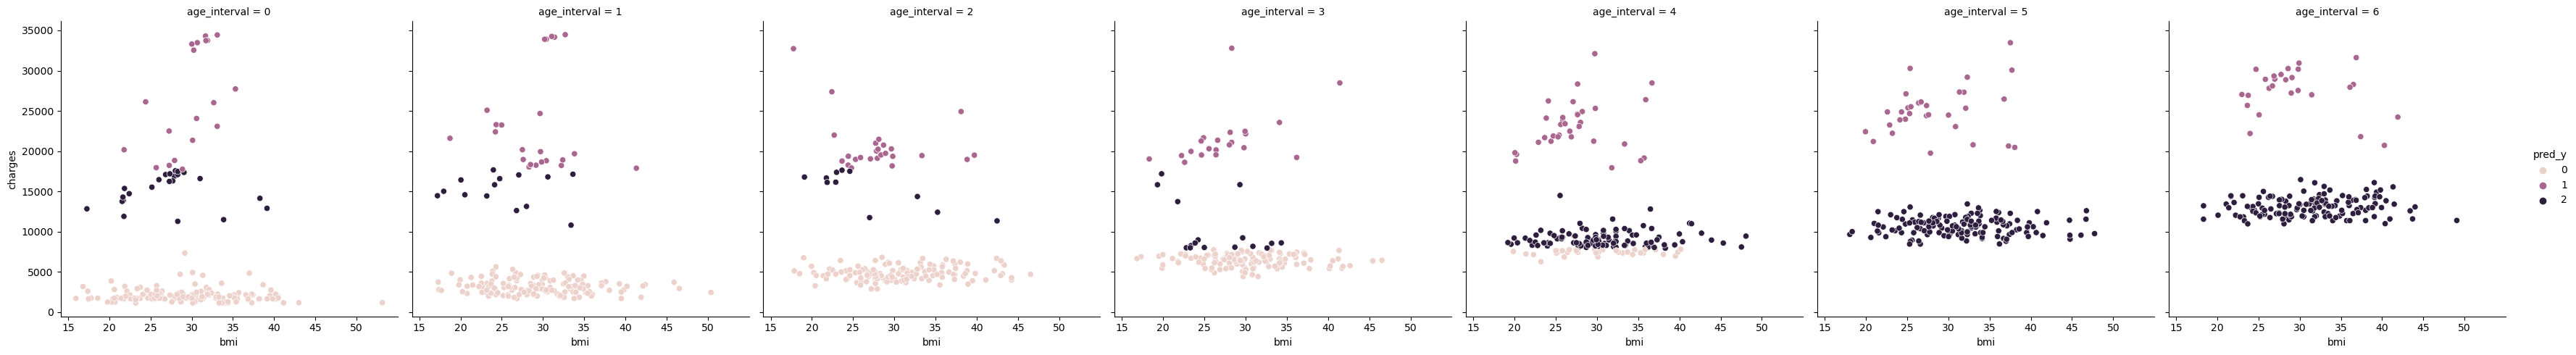

In [ ]:
kmeans = KMeans(n_clusters = 3, #numero de clusters
init = 'random', n_init = 50, #algoritmo que define a posição dos clusters de maneira mais assertiva
max_iter = 100) #numero máximo de iterações
pred_y = kmeans.fit_predict(dataframe)

dataframe['pred_y'] = pred_y
dataframe.reset_index()

sns.relplot(data=dataframe, x='bmi', y='charges', hue='pred_y', col='age_interval') #posicionamento dos eixos x e y
plt.show()

In [ ]:
group_A = dataframe[dataframe['pred_y']==0]
group_B = dataframe[dataframe['pred_y']==1]
group_C = dataframe[dataframe['pred_y']==2]

print(f"Retorno Financeiro: R$ {round(sum(group_A['charges']),2)}")
print(f"Retorno Financeiro: R$ {round(sum(group_B['charges']),2)}")
print(f"Retorno Financeiro: R$ {round(sum(group_C['charges']),2)}")

Retorno Financeiro: R$ 2401294.39
Retorno Financeiro: R$ 4276539.13
Retorno Financeiro: R$ 5223903.24


# What's the value to offer?

In [ ]:
X = dataframe.drop(['charges'], axis=1)
y = dataframe.charges
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

mlr = LinearRegression()  
mlr.fit(x_train, y_train)

y_pred_mlr= mlr.predict(x_test)

x_test['pred'] = y_pred_mlr

In [ ]:
from sklearn import metrics
meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))
print('R squared: {:.2f}'.format(mlr.score(X,y)*100))
print('Mean Absolute Error:', round(meanAbErr,2))
print('Mean Square Error:', round(meanSqErr,2))
print('Root Mean Square Error:', round(rootMeanSqErr,2))

R squared: 61.20
Mean Absolute Error: 2358.06
Mean Square Error: 15917905.35
Root Mean Square Error: 3989.72
